In [10]:
import numpy as np
import tensorflow as tf
import matplotlib.pylab as plt

from modules.spectral_pool import spectral_pool, max_pool, l2_loss_images
from modules.create_images import open_image, downscale_image
from modules.utils import load_cifar10

np.set_printoptions(precision=3, linewidth=200)

% matplotlib inline
% load_ext autoreload
% autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
images, _ = load_cifar10(1, get_test_data=False)

file already downloaded..
getting batch 1


In [3]:
images.shape

(10000, 32, 32, 3)

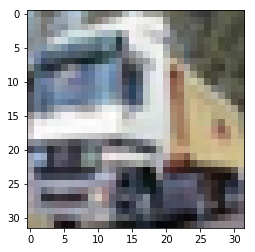

In [4]:
plt.imshow(images[1], cmap='gray')

Minibatch 1


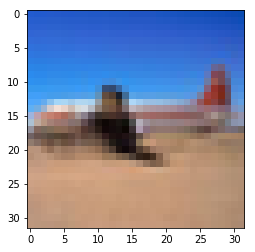

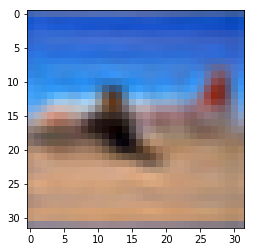

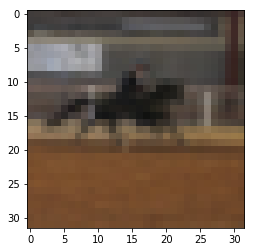

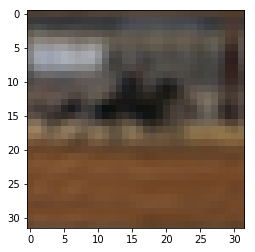

Minibatch 2


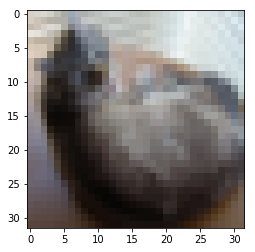

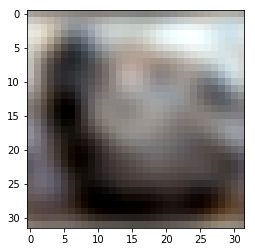

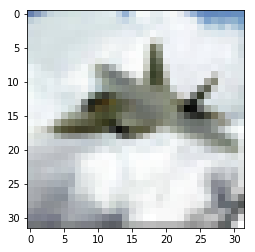

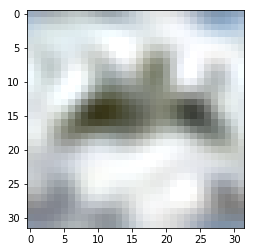

Minibatch 3


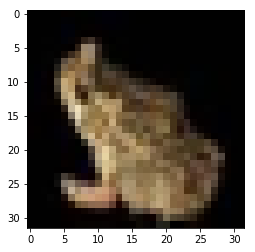

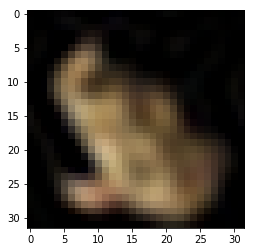

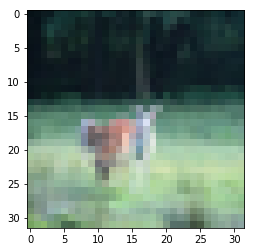

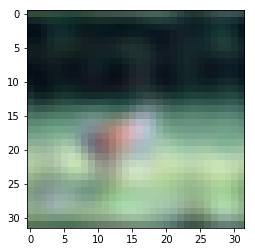

In [104]:
from modules.frequency_dropout import test_frequency_dropout

batch_size = 2
minibatch_cutoff = tf.random_uniform([], 2, 8)

for iter_idx in range(3):
    random_selection_indices = np.random.choice(len(images), size=batch_size)
    random_selection = images[random_selection_indices]
    downsampled_images = np.moveaxis(
        test_frequency_dropout(
            np.moveaxis(random_selection, 3, 1),
            minibatch_cutoff
        ), 1, 3
    )
    print('Minibatch {0}'.format(iter_idx+1))
    for i in range(batch_size):
        plt.imshow(random_selection[i], cmap='gray')
        plt.show()
        plt.imshow(np.clip(downsampled_images[i],0,1), cmap='gray')
        plt.show()

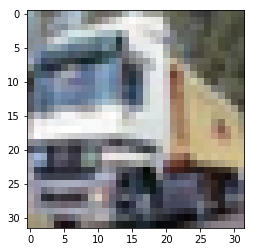

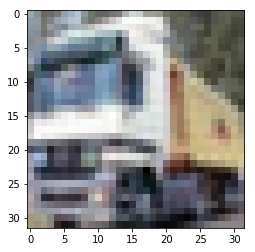

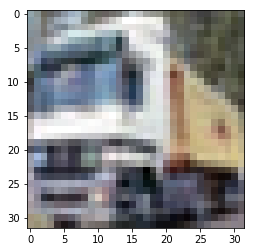

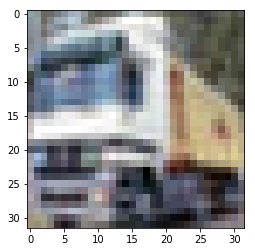

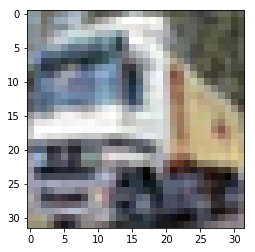

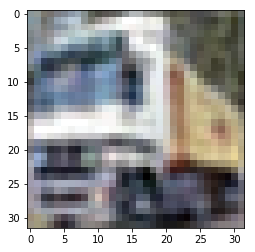

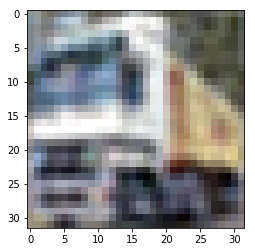

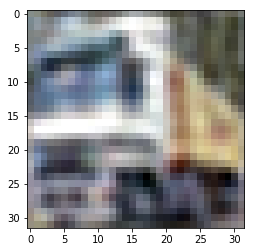

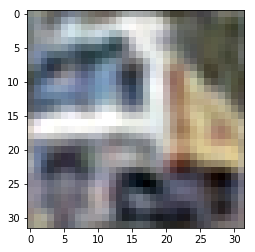

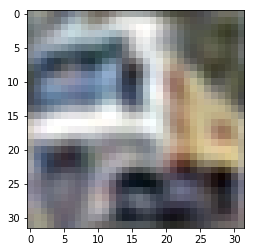

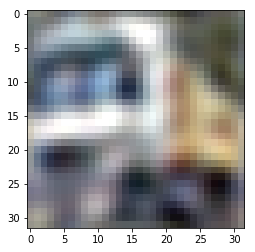

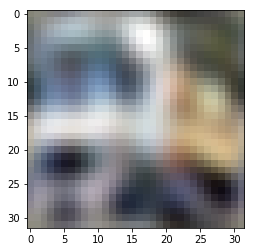

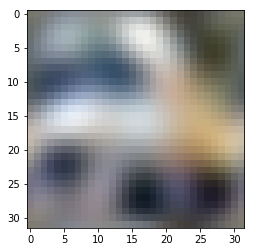

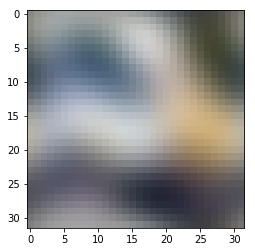

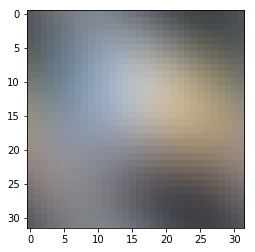

In [50]:
one_image = np.moveaxis(images[1],-1,0)
one_image_fft = np.fft.fft2(one_image)

for cutoff in range(16,1,-1):
    one_image_trunc = one_image_fft.copy()
    one_image_trunc[:,:,cutoff:(32-cutoff+1)] = 0
    one_image_trunc[:,cutoff:(32-cutoff+1),:] = 0
    one_image_back_trunc = np.real(np.fft.ifft2(one_image_trunc))
    one_image_back_clipped = np.clip(one_image_back_trunc, 0, 1)
    plt.imshow(np.moveaxis(one_image_back_clipped,0,-1),cmap='gray')
    plt.show()



In [49]:
np.min(one_image_back_trunc)

-0.048188443459048602

In [53]:
height = 8

mid = height // 2
if height % 2 == 1:
    go_to = mid + 1
else:
    go_to = mid
indexes = np.concatenate((np.arange(go_to), np.arange(mid, 0, -1))).astype(np.float32)

xs = np.broadcast_to(indexes,(height,height))
ys = np.broadcast_to(np.expand_dims(indexes,-1),(height,height))
highest_frequency = np.maximum(xs, ys)
print(highest_frequency)

[[ 0.  1.  2.  3.  4.  3.  2.  1.]
 [ 1.  1.  2.  3.  4.  3.  2.  1.]
 [ 2.  2.  2.  3.  4.  3.  2.  2.]
 [ 3.  3.  3.  3.  4.  3.  3.  3.]
 [ 4.  4.  4.  4.  4.  4.  4.  4.]
 [ 3.  3.  3.  3.  4.  3.  3.  3.]
 [ 2.  2.  2.  3.  4.  3.  2.  2.]
 [ 1.  1.  2.  3.  4.  3.  2.  1.]]


[ 3.49   3.173]
fbf
[[ 0.61   0.912  0.064  0.522  0.709  0.563  0.309  0.503]
 [ 0.169  0.107  0.11   0.25   0.23   0.985  0.725  0.536]
 [ 0.115  0.411  0.973  0.572  0.136  0.002  0.422  0.178]
 [ 0.876  0.295  0.069  0.091  0.263  0.17   0.673  0.804]
 [ 0.775  0.18   0.346  0.652  0.899  0.788  0.419  0.536]
 [ 0.849  0.048  0.017  0.147  0.211  0.579  0.039  0.307]
 [ 0.95   0.863  0.581  0.93   0.555  0.206  0.477  0.576]
 [ 0.819  0.374  0.259  0.059  0.086  0.691  0.615  0.651]]


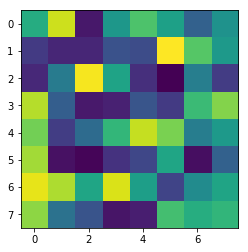

fbf_fft2
[[ 28.837+0.j      2.125+2.434j   2.155+0.14j    2.024-0.087j  -0.134+0.j      2.024+0.087j   2.155-0.14j    2.125-2.434j]
 [  0.467+1.901j   0.340+1.234j  -0.879+1.03j   -0.661+0.333j  -1.935-0.38j   -0.813+1.591j  -1.602+3.67j   -0.402+0.826j]
 [  0.837+1.489j  -1.169+4.583j   1.996-1.143j   0.482-0.301j  -0.995+1.138j  -0.671-1.095j   3.107+0.864j  -1.032-0.108j]
 [ -1.270-2.757j   2.543-1.29j    1.877-0.85j   -1.816-0.397j  -0.244+0.608j   0.412+1.47j    0.751-0.811j   0.602+0.866j]
 [  4.632+0.j     -1.932-5.502j   0.162+0.946j  -1.609-1.632j   0.030+0.j     -1.609+1.632j   0.162-0.946j  -1.932+5.502j]
 [ -1.270+2.757j   0.602-0.866j   0.751+0.811j   0.412-1.47j   -0.244-0.608j  -1.816+0.397j   1.877+0.85j    2.543+1.29j ]
 [  0.837-1.489j  -1.032+0.108j   3.107-0.864j  -0.671+1.095j  -0.995-1.138j   0.482+0.301j   1.996+1.143j  -1.169-4.583j]
 [  0.467-1.901j  -0.402-0.826j  -1.602-3.67j   -0.813-1.591j  -1.935+0.38j   -0.661-0.333j  -0.879-1.03j    0.340-1.234j]]
fbf_ba

IndexError: index 16 is out of bounds for axis 1 with size 8

In [96]:
mu = np.random.multivariate_normal(mean=[3.5,3.5], cov=[[1,0],[0,1]])
print(mu)

fbf = np.exp(-0.5 * (xs - mu[0]) ** 2) * np.exp(-0.5 * (ys - mu[1]) ** 2)
fbf = np.random.uniform(size=(8,8))
print('fbf')
print(fbf)
plt.imshow(fbf)
plt.show()
fbf_fft2 = np.fft.fft2(fbf)
print('fbf_fft2')
print(fbf_fft2)
fbf_back_complex = np.fft.ifft2(fbf_fft2)
print('fbf_back_complex')
print(fbf_back_complex)
fbf_back = np.real(fbf_back_complex)
print('fbf_back')
print(fbf_back)
fbf_trunc = fbf_fft2.copy()
fbf_trunc[:,16] = 0
fbf_trunc[16,:] = 0
fbf_back_trunc_complex = np.fft.ifft2(fbf_trunc)
print('fbf_back_trunc_complex')
print(fbf_back_trunc_complex)
fbf_back_trunc = np.real(fbf_back_trunc_complex)
print('fbf_back_trunc')
print(fbf_back_trunc)
plt.imshow(fbf_back_trunc)
plt.show()

print(np.min(fbf))
print(np.max(fbf))
print(np.mean(fbf))
print(np.std(fbf))
print()
print(np.min(fbf_back_trunc))
print(np.max(fbf_back_trunc))
print(np.mean(fbf_back_trunc))
print(np.std(fbf_back_trunc))
print()
print(np.min(fbf_back_trunc - fbf))
print(np.max(fbf_back_trunc - fbf))
print(np.mean(fbf_back_trunc - fbf))
print(np.std(fbf_back_trunc - fbf))

In [74]:
# random_thrtf.random_uniform([]).get_shape()


[[ 1.  1.  1.  0.  0.  1.  1.]
 [ 1.  1.  1.  0.  0.  1.  1.]
 [ 1.  1.  1.  0.  0.  1.  1.]
 [ 0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.]
 [ 1.  1.  1.  0.  0.  1.  1.]
 [ 1.  1.  1.  0.  0.  1.  1.]]


[[ 1.  1.  1. ...,  1.  1.  1.]
 [ 1.  1.  1. ...,  1.  1.  1.]
 [ 1.  1.  1. ...,  1.  1.  1.]
 ..., 
 [ 1.  1.  1. ...,  1.  1.  1.]
 [ 1.  1.  1. ...,  1.  1.  1.]
 [ 1.  1.  1. ...,  1.  1.  1.]]


### max pool test

In [5]:
images_pool = max_pool(images, 2)
images_pool.shape

(10000, 32, 32, 3)

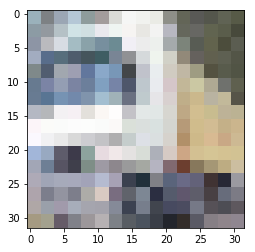

In [6]:
plt.imshow(images_pool[1], cmap='gray')

### spectral pool test

In [7]:
images.shape

(10000, 32, 32, 3)

In [8]:
images = np.moveaxis(images, -1, 1)

im_transformed (1, 3, 21, 21)
im_ifft (1, 3, 21, 21)
im_out (1, 21, 21, 3)


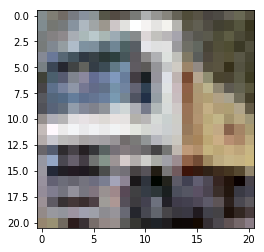

In [9]:
images_sp = spectral_pool(images[1:2], 21)[0]
plt.imshow(images_sp[0], cmap='gray')

In [ ]:
images_sp = spectral_pool(images[:10], 17)[0]
plt.imshow(images_sp[1], cmap='gray')

## Iterate and plot

In [ ]:
# calculate losses for max_pool:
pool_size_mp = [2, 4, 8, 16, 32]
max_pool_errors = []
for s in pool_size_mp:
    images_pool = max_pool(images, s)
    loss = l2_loss_images(images, images_pool)
    max_pool_errors.append(loss)

In [ ]:
# calculate losses for spectral_pool:
# takes a long time to run, could be optimized but not high priority
filter_size_sp = np.arange(1, 32, 2)
spec_pool_errors = []
for s in filter_size_sp:
    images_sp = spectral_pool(images, s)[0]
    loss = l2_loss_images(images, images_sp)
    spec_pool_errors.append(loss)

In [ ]:
pool_frac_kept = [1/x**2 for x in pool_size_mp]
sp_frac_kept = [(x/32.)**2 for x in filter_size_sp]

In [ ]:
fig, ax = plt.subplots(1, 1)
ax.semilogy(pool_frac_kept, max_pool_errors, basey=2,
            marker='o', linestyle='--', color='r', label='Max Pooling')
ax.semilogy(sp_frac_kept, spec_pool_errors, basey=2,
            marker='o', linestyle='--', color='b', label='Spectral Pooling')
ax.legend()
ax.grid(linestyle='--', alpha=0.5)
ax.set_xlabel('Fraction of Parameters Kept')
ax.set_ylabel('Relative Loss')